# Выпускной проект Яндекс.Практикум

Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Помимо основного датасета есть два датасета с информацией о рекламных активностях. 

# ШАГ 1: ПРЕДОБРАБОТКА ДАННЫХ

На данном этапе выгрузим данные, проанализируем их на предмет пропусков, дубликатов (в том числе неявных), изучим распределение данных. При необходимости проведем предобработку.

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats as st
import scipy.stats as stats

In [2]:
game_actions = pd.read_csv('/datasets/game_actions.csv')
ad_costs = pd.read_csv('/datasets/ad_costs.csv')
user_source = pd.read_csv('/datasets/user_source.csv')

In [3]:
display(game_actions.head(5))
display(ad_costs.head(5))
display(user_source.head(5))

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [4]:
display(game_actions.info())
display(ad_costs.info())
display(user_source.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


None

In [5]:
display(game_actions.isna().sum())
display(ad_costs.isna().sum())
display(user_source.isna().sum())

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

source    0
day       0
cost      0
dtype: int64

user_id    0
source     0
dtype: int64

In [6]:
display(game_actions.duplicated().sum())
display(ad_costs.duplicated().sum())
display(user_source.duplicated().sum())

1

0

0

In [7]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
ad_costs['day'] = pd.to_datetime(ad_costs['day'])

**Вывод:** На данном этапе мы изучили данные во всех датасетах, проверили данные на пропуски, дубликаты, форматы данных. При первичном анализе были выявлены дубликаты, пропуски, неверный формат даты в датасете game_actions, а аткже неверный формат даты в датасете ad_costs. Мы изменили неверные форматы даты в обоих датасетах, переходим к анализу пропусков и дубликатов.

**Важно:** Пропущенные значения в большом количестве содержатся в столбцах building_type (7683 штук) и project_type (133774 штук), изучим их.

In [8]:
game_actions['building_type'].value_counts()

spaceport          59325
assembly_shop      54494
research_center    14138
Name: building_type, dtype: int64

In [9]:
game_actions['building_type'].unique()

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

In [10]:
game_actions[game_actions['building_type'].isna()]

,event_datetime,event,building_type,user_id,project_type
6659,2020-05-04 19:47:29,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,NaN
13134,2020-05-05 13:22:09,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,NaN
15274,2020-05-05 18:54:37,finished_stage_1,NaN,70db22b3-c2f4-43bc-94ea-51c8d2904a29,NaN
16284,2020-05-05 21:27:29,finished_stage_1,NaN,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,NaN
19650,2020-05-06 06:02:22,finished_stage_1,NaN,58e077ba-feb1-4556-a5a0-d96bd04efa39,NaN
...,...,...,...,...,...
135632,2020-06-04 15:50:38,finished_stage_1,NaN,22cce310-fe10-41a2-941b-9c3d63327fea,NaN
135633,2020-06-04 17:56:14,finished_stage_1,NaN,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,NaN
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN


Предполагаем, что значения nan связаны, с тем, что игрок завершил игру, проверим это далее

In [11]:
game_actions[game_actions['building_type'].isna()]['event'].unique()

array(['finished_stage_1', 'project'], dtype=object)

**Вывод:** Выдвинутая гипотеза подтвердилась, в таком случае nan можно заполнить фразой об отсутсвии постороенного здания. Данные пропуски обсусловлены механикой сбора данных и не являются ошибками.

In [12]:
game_actions['building_type'] = game_actions['building_type'].fillna('no_buildings')

Переходим к анализу столбца project_type

In [13]:
game_actions['project_type'].value_counts()

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

In [14]:
game_actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

In [15]:
game_actions[game_actions['project_type'].isna()]

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN
...,...,...,...,...,...
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135636,2020-06-05 02:25:12,finished_stage_1,no_buildings,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN
135638,2020-06-05 12:12:27,finished_stage_1,no_buildings,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN


**Вывод:** В данных отсутсвует информация о завершении уровня путем победы над врагом, только о постройке орбитальной станции. В данном случае, это связано с механикой заполнения данных, не будет их заполнять какими-то значениями, оставим как есть

In [16]:
display(game_actions.isna().sum())

event_datetime         0
event                  0
building_type          0
user_id                0
project_type      133774
dtype: int64

In [17]:
game_actions[game_actions.duplicated()]

,event_datetime,event,building_type,user_id,project_type
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


Данный дубликат можно удалить, на качество данных он не повлияет

In [18]:
game_actions = game_actions.drop_duplicates().reset_index(drop=True)

**ИТОГОВЫЙ ВЫВОД:** выгрузив и изучив датасеты, нами была выполнена предобработка данных, включая изменение формата даты, заполнение пропущенных значений, удаление дубликата. Можно переходить к следующему этапу проекта, но для удобства выведем первые 5 строк каждого датасета

In [19]:
display(game_actions.head(5))
display(ad_costs.head(5))
display(user_source.head(5))

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [20]:
game = game_actions.merge(user_source, how = 'left', on = 'user_id')
game

,event_datetime,event,building_type,user_id,project_type,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,facebook_ads
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct
...,...,...,...,...,...,...
135634,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN,instagram_new_adverts
135635,2020-06-05 02:25:12,finished_stage_1,no_buildings,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,yandex_direct
135636,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN,youtube_channel_reklama
135637,2020-06-05 12:12:27,finished_stage_1,no_buildings,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,facebook_ads


# ШАГ 2: ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

В данном разделе будут изучены:

1 часть - общая информации о пользователях игры (как они проходили 1 уровень, сколько времени затратили на его прохождение, анализ каналов их привлечения

2 часть - расчет показателя Retention для пользователей игры

In [21]:
print(game_actions['user_id'].nunique())
print(game_actions['event'].nunique())
print(game_actions['event'].count())

13576
3
135639


In [22]:
median_event = game_actions.groupby('user_id')['event'].count().median()
median_event

10.0

**Вывод:** В датасете представлена информация о 13576 пользователях игры, которые совершили 135639 событий (3 уникальных) в игре. На одного пользователя, медаинно приходится 10 событий. 

Далее посмотрим на количество пользователей, которые завершили/не завершили 1 уровень.

In [23]:
finished = game_actions[game_actions['event'] == 'finished_stage_1']
finished = finished['user_id']
finished_users = game_actions.query('user_id in @finished')
not_finished_users = game_actions.query('user_id not in @finished')
num_finished = len(finished_users['user_id'].unique())
num_not_finished = len(not_finished_users['user_id'].unique())

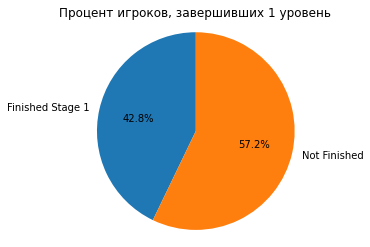

In [24]:
labels = ['Finished Stage 1', 'Not Finished']
sizes = [num_finished, num_not_finished ]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

ax1.axis('equal')
plt.title('Процент игроков, завершивших 1 уровень')


plt.show()


По графику видно, что большинство юзеров не завершили 1 уровень (57.2%), против завершивших (42.8%)

building_type
assembly_shop      54494
research_center    14137
spaceport          59325
Name: user_id, dtype: int64

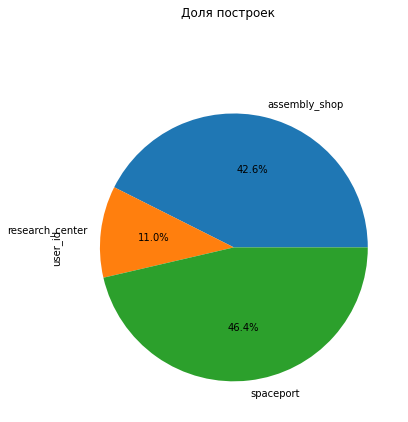

In [25]:
buildings = game_actions[game_actions['building_type'] != 'no_buildings']

build = buildings.groupby('building_type')['user_id'].count()
display(build)

build.plot.pie(figsize = (6,7), autopct="%.1f%%", subplots = True, title='Доля построек')
plt.show()

Основными типами построек являются spaceport (космодром) - 46.4%, assembly_shop (сборочный цех) - 42.6% и меньше всего research_center (исследовательский центр) - 11%.

Посмотрим теперь каким путем пользователи завершали 1 уровень - через победу над игроком или через проект

In [26]:
project = game_actions[game_actions['project_type'] == 'satellite_orbital_assembly']
project = project['user_id'].nunique()
not_project = finished_users['user_id'].nunique() - project

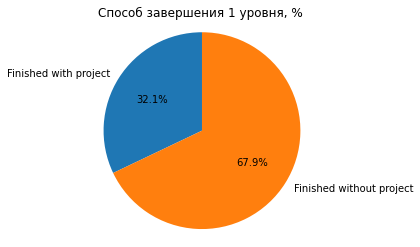

In [27]:
labels = ['Finished with project', 'Finished without project']
sizes = [project, not_project]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

ax1.axis('equal')
plt.title('Способ завершения 1 уровня, % ')


plt.show()

По графику видно, что игроки проходят 1 уровень с бОльшей помощью pvp (победы над врагом) - 67.9%, нежели прибегая к постройке космической станции (реализации проекта)

**Вывод:** На данном этапе анализа было выяснено, что в датасете имеется информация о 13576 уникальных пользователя, которые с 4-10 марта совершили 135639 событий (уникальных 3 события). В основном, игроки использовали для завершения 1 уровня победу над врагом, при этом большинство игроков еще не завершили 1 уровень. Те, игроки, которые выбрали стратегию "pve", в основном, строят космодромы.

Далее изучим информацию о трафике, то есть поймем из каких каналов приходят юзеры игры

In [28]:
user_source.head(10)

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads
5,003b80c6-4164-4157-bb2a-03d0181d39c4,yandex_direct
6,003ee7e8-6356-4286-a715-62f22a18d2a1,instagram_new_adverts
7,004074f8-251a-4776-922c-8348dca1a2f6,facebook_ads
8,00440efd-aa50-4b4b-aae8-ffcd1782729d,facebook_ads
9,00464e5e-28ed-4be6-bf44-517ef7b3937b,yandex_direct


,user_id
source,
yandex_direct,4817
instagram_new_adverts,3347
facebook_ads,2726
youtube_channel_reklama,2686


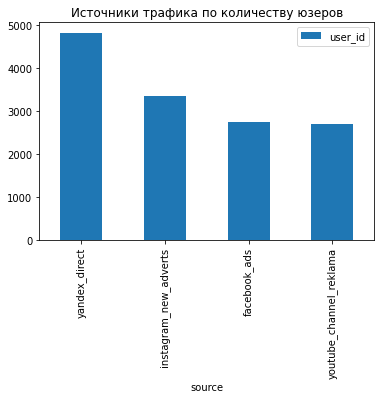

In [29]:
users_count = game.groupby('source').agg({'user_id': 'nunique'}).sort_values( by = 'user_id', ascending = False)
display(users_count)
users_count.plot.bar()
plt.title("Источники трафика по количеству юзеров")
plt.show()

**Вывод:** Большинство игроков пришли из Яндекс.Директа (4817 юзеров), наименьшее число пришло из канала youtube_channel_reklama (2686 юзеров)

Изучим стоимость привлечения из каждого канала

,cost
source,
yandex_direct,2233.11
instagram_new_adverts,2161.44
facebook_ads,2140.90
youtube_channel_reklama,1068.12


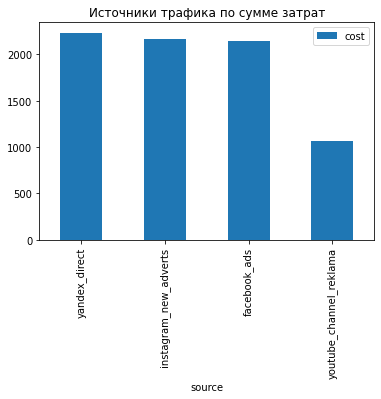

In [30]:
traffic_costs = ad_costs.groupby('source').agg({'cost':'sum'}).sort_values(by = 'cost', ascending = False).round(2)
display(traffic_costs)
traffic_costs.plot.bar()
plt.title("Источники трафика по сумме затрат")
plt.show()

source
yandex_direct              0.463589
instagram_new_adverts      0.645784
facebook_ads               0.785363
youtube_channel_reklama    0.397662
dtype: float64

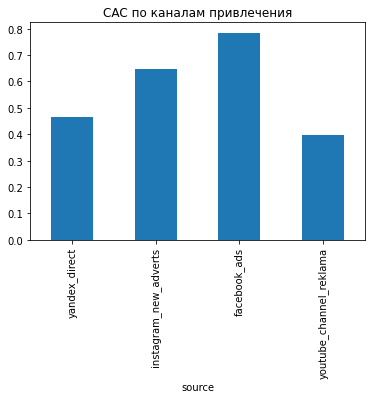

In [31]:
cac = traffic_costs['cost'] / users_count['user_id']
display(cac)
cac.plot.bar()
plt.title("CAC по каналам привлечения")
plt.show()

Наибольшая суммарная стоимость затрат на привлечение пользователей у канала - yandex_direct, минимальная у youtube_channel_reklama. Видно, что количество привлеченных юзеров кореллирует с суммарной стоимостью затрат на привлечение в каждом из каналов трафика. Более того, рассчитав cac, мы получили, что Яндекс.Директ при его высокой эффективности обладает одной из наименьших стоимостей привлечения юзеров

**ИТОГОВЫЙ ВЫВОД:** первый этап анализа завершен, можно переходить к когортному анализу. В нем мы изучим временное распределние пользователей в игре, рассчитаем показатель Retention, DAU, TiG (time in game)

In [32]:
game_actions['day_event'] = game_actions['event_datetime'].dt.date
game_actions

,event_datetime,event,building_type,user_id,project_type,day_event
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04
...,...,...,...,...,...,...
135634,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN,2020-06-05
135635,2020-06-05 02:25:12,finished_stage_1,no_buildings,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,2020-06-05
135636,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN,2020-06-05
135637,2020-06-05 12:12:27,finished_stage_1,no_buildings,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,2020-06-05


2884.88

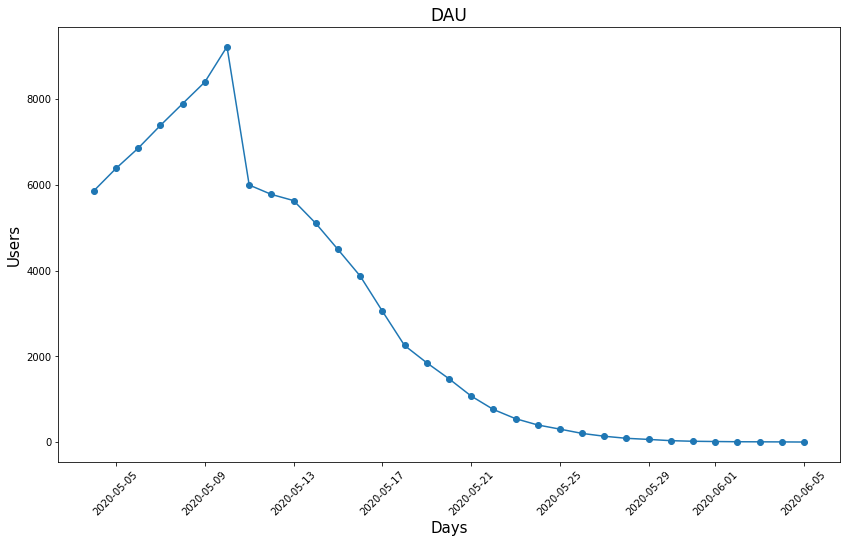

In [33]:
dau = game_actions.groupby('day_event')['user_id'].nunique()
display(game_actions.groupby('day_event')['user_id'].nunique().mean().round(2))
dau.plot(marker='o', figsize=(14, 8))
plt.title('DAU', fontsize=17)
plt.xlabel('Days', fontsize=15)
plt.ylabel('Users', fontsize=15)
plt.xticks(rotation=45)
plt.show()


**Вывод:** По графику мы можем наблюдать как изменялось ежедневное количество активных пользователей приложения по дням (пик приходится как раз на 4-10 мая, когда пользователи только начинают использовать приложение), ладее наблюдается существенное снижение активности. Более того, в среднем, ежедневно игрой пользуются 2884 уникальных пользователя

Посмотрим на то, как ведут себя пользователи из разных каналов, чтобы понимать, какой из них приносит нам наиболее мотивированный трафик.

In [34]:
def buildings_by_channel(data):
    user_build = data.groupby('user_id')['building_type'].count().reset_index()
    user_build.hist()
    print('Среднее количество построек', (user_build['building_type'].sum() / user_build['user_id'].count()).round(1))

In [35]:
yandex = game.query('source == "yandex_direct"')
instagram = game.query('source == "instagram_new_adverts"')
facebook = game.query('source == "facebook_ads"')
youtube =  game.query('source == "youtube_channel_reklama"')

Среднее количество построек 9.9
Среднее количество построек 10.1
Среднее количество построек 10.2
Среднее количество построек 9.9


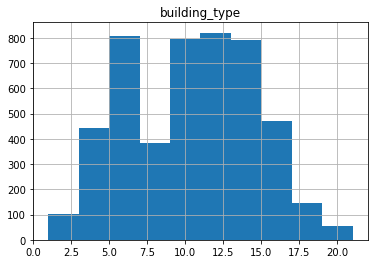

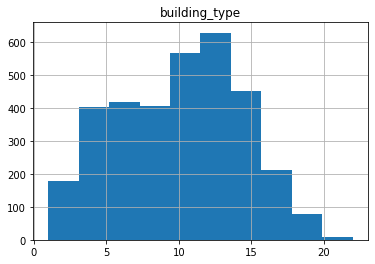

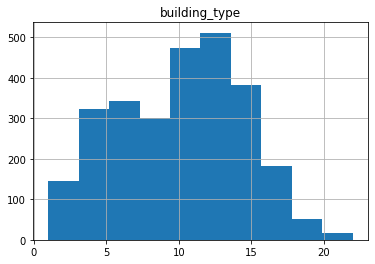

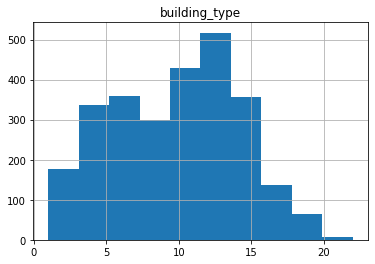

In [36]:
buildings_by_channel(yandex)
buildings_by_channel(instagram)
buildings_by_channel(facebook)
buildings_by_channel(youtube)

**Вывод:** Можно сказать, что пользователи не отличаются между собой по среднему количеству построек, что говорит о том, что все же трафик у нас одинаковый в плане его качества, то есть стоит оптимизировать объему на закупку трафика в более эффективных каналах (таких как Яндекс.Директ) и уменьшить в наименее эффективных (таких как Facebook_ads)

In [37]:
game

,event_datetime,event,building_type,user_id,project_type,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,facebook_ads
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct
...,...,...,...,...,...,...
135634,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN,instagram_new_adverts
135635,2020-06-05 02:25:12,finished_stage_1,no_buildings,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,yandex_direct
135636,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN,youtube_channel_reklama
135637,2020-06-05 12:12:27,finished_stage_1,no_buildings,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,facebook_ads


In [38]:
def percentage(data):
    percentage = data[data['event'] == 'finished_stage_1']
    percentage= percentage['user_id']
    finished_users_perc = data.query('user_id in @percentage')
    not_finished_users_perc = data.query('user_id not in @percentage')
    num_finished_perc = len(finished_users_perc['user_id'].unique())
    num_not_finished_perc = len(not_finished_users_perc['user_id'].unique())
    labels = ['Finished Stage 1', 'Not Finished']
    sizes = [num_finished_perc, num_not_finished_perc ]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')
    plt.title('Процент игроков, завершивших 1 уровень')
    plt.show()

In [39]:
yandex = game.query('source == "yandex_direct"')
instagram = game.query('source == "instagram_new_adverts"')
facebook = game.query('source == "facebook_ads"')
youtube =  game.query('source == "youtube_channel_reklama"')

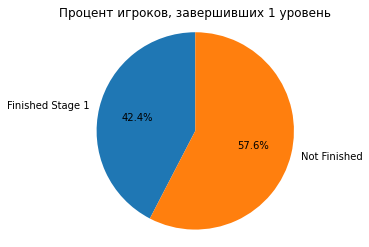

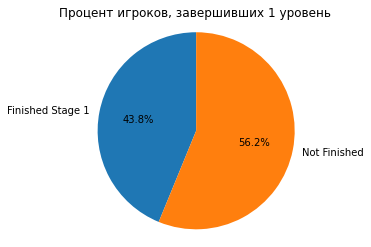

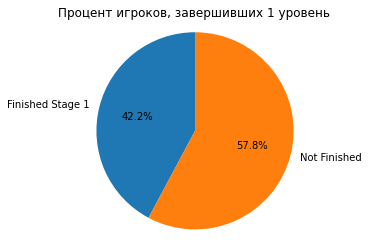

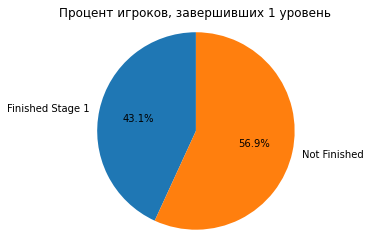

In [40]:
percentage(yandex)
percentage(instagram)
percentage(facebook)
percentage(youtube)

**Вывод:** процент завершения уровня существенно не зависит от канала привлечения, мы видим, что проценты крайне близки, что опять же говорит о том, что трафик не отличается по качеству из разных каналов

In [41]:
first_event = game_actions.groupby(['user_id']).agg(first_ts = ('event_datetime', 'first')).reset_index()
game_actions = game_actions.merge(first_event, how='left', on='user_id')
game_actions['first_ts'] = game_actions['first_ts'].dt.date
last_event = game_actions.groupby(['user_id']).agg(last_ts = ('event_datetime', 'last')).reset_index()
game_actions = game_actions.merge(last_event, how='left', on='user_id')
game_actions['last_ts'] = game_actions['last_ts'].dt.date
game_actions['cohort_lifetime'] = game_actions['day_event'] - game_actions['first_ts']
game_actions['cohort_lifetime'] = game_actions['cohort_lifetime'] / np.timedelta64(1,'D')
time_in_game = game_actions.groupby('user_id')['cohort_lifetime'].max().reset_index()
time_in_game.columns = ['user_id', 'TiG']
game_actions = game_actions.merge(time_in_game, on='user_id')

In [42]:
game_actions.head()

,event_datetime,event,building_type,user_id,project_type,day_event,first_ts,last_ts,cohort_lifetime,TiG
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,2020-05-04,2020-05-10,0.0,6.0
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04,2020-05-10,1.0,6.0
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04,2020-05-10,1.0,6.0
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04,2020-05-10,1.0,6.0
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-06,2020-05-04,2020-05-10,2.0,6.0


In [43]:
level_finish = game_actions.query('event == "finished_stage_1"')
level_finish['TiG'].median()

12.0

In [44]:
level_not_finish = game_actions.query('event != "finished_stage_1"')
level_not_finish['TiG'].median()

11.0

**Вывод:** Игроки, которые завершили первый уровень, проводили медианно 12 дней в игре, в то время как те, кто не завершил 1 уровень, проводили в игре медианно 11 дней, то есть на 1 день меньше. Скорее всего, игроки просто уставали проходить 1 уровень и не желали продолжать играть дальше

In [45]:
cohorts = game_actions.groupby(['first_ts','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()
cohorts_0 = cohorts[cohorts['cohort_lifetime'] == 0][['first_ts', 'user_id']]
cohorts_0.columns = ['first_ts', 'uid']
cohorts = cohorts.merge(cohorts_0,on='first_ts') 
cohorts['retention'] = cohorts['user_id'] / cohorts['uid'] 
retention_pivot = cohorts.pivot_table(index='first_ts',columns='cohort_lifetime',values='retention',aggfunc='sum')

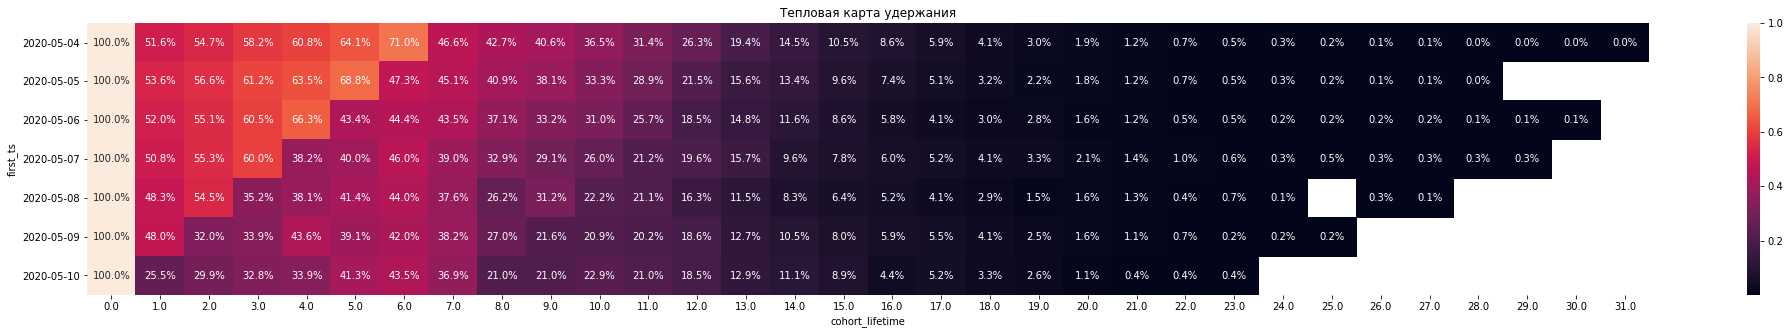

In [46]:
plt.figure(figsize=(35, 5))
sns.heatmap(
    retention_pivot,
    annot=True, 
    fmt='.1%',  
)
plt.title('Тепловая карта удержания')
plt.show()

**Вывод:** если взять довольно стандартные дни удержания (3,7,14,30 дней), на которые чаще всего обращают внимание при анализе когорт, то можно выявить следующие факты:

 - когорты 4-7 мая умеют удержания 3 дня выше 60%, что является высоким показателем, игроки в данных когортах были серьезно заинтересованы в игре
 
 
 
 - когорта от 4 мая имеет наибольшие retention rate 7,14 дня, однако к 14 дню % удержанных во всех когортах невысокий (от 10 до 14%)
 
 
 
 - к 30 дню удержание стремится к 0, то есть через месяц пользователи перестают окончательно проходить 1 уровень игры (это связано с тем, что было выяснено ранее - медианное время прохождения игры 12 дней)
 
 
 
 - Стоит отметить, что retention расчитан для 1 уровня, данный показатель используется больше для подтверждения правильности собственных расчетов. Особо на него обращать внимание не стоит в рамках анализа поведения игроков внутри игры

**ИТОГОВЫЙ ВЫВОД**

В рамках исследовательского анализа данных были получены следующие результаты:

 - За период с 4 по 10 мая в игру поиграло 13576 юзеров, которые совершили 135639 события (3 уникальных). На одного игрока медианно приходится 10 событий;
 
 
 - Большинство игроков не завершили 1 уровень, только 42.8% игроков дошли до конца 1 уровня;
 
 
 - Игроки, которые выбрали стратегию завершения 1 уровня с помощью проекта, в основном, строят космодромы (46.4%);
 
 
 
 - Больше всего игроков пришли из Яндекс.Директ (4817), в который вложили больше всего маркетинговых ресурсов (2233 у.е.), при этом данных канал является 2 по эффективности после Facebook_ads по показателю стоимости привлечения 1 игрока;
 
 
 
 - Наименее эффективным маркетингвым каналом привлечения можно назвать facebook_ads;
 
 
 - В среднем ежедневно в игру заходтя 2885 игроков, наибольшая активность 10 мая, затем количество активных игроков снижалось ежедневно;
  
  
  
 - Показатель Retention находится на довольно высоком уровне до 12 дня у всех когорт (медианное время прохождения 1 уровня), затем показатель снижается и к 30 дню стремится к 0
 
 
 - Однако показатель Retention расчитан исключительно для игроков 1 уровня с целью подтверждения правильности расчета о медианном времени прохождения 1 уровня игры - при принятии решений на него можно не полагаться
 
 
 - Среднее количество построек, а также % прохождения 1 уровня не отличается по каналам привлечения, можно сделать вывод о том, что трафик в каждом канале одинаково мотивирован
 
 
Переходим к анализу гипотез

# ШАГ 3: ПРОВЕРКА ГИПОТЕЗ

В данном разделе будет проверено 2 гипотезы

1 - существует различие в среднем времени прохождения 1 уровня по способу его прохождения : через проект или через победу над врагом
    
2 - существует различие в среднем времени прохождения 1 уровня в зависимости от источника привлечения

1 гипотеза - так как нам необходимо проверить есть ли статистическое различие в среднем врмени прохождения 1 уровня, мы будем использовать t-тест (то есть проверять гипотезу о равенстве средних двух генеральных совокупностей)


2 гипотеза - в данном случае, так как у нас 2 и более выборки, чтобы не делать несколько отдельных t-тестов, возспользуемся тестом ANOVA

Переходим к проверке 1 гипотезы:
    
Н0: Среднее время прохождения 1 уровня не зависит от способа его прохождения



Н1: Среднее время прохождения 1 уровня зависит от способа его прохождения

In [47]:
pve = game_actions.query('project_type == "satellite_orbital_assembly"')
pve['tig'] = pve['TiG']*24
pro = pve['user_id'].unique()
pas = game_actions[game_actions['event'] == 'finished_stage_1']
pas = pas['user_id'].unique()
not_in_pro = np.setdiff1d(pas, pro)
pvr= game_actions.query('user_id in @not_in_pro')
pvp = pvr.query('event == "finished_stage_1"')
pvp['tig'] = pvp['TiG']*24
display(pve['tig'].mean())
display(pvp['tig'].mean())

/tmp/ipykernel_63/1651645556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pve['tig'] = pve['TiG']*24
/tmp/ipykernel_63/1651645556.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pvp['tig'] = pvp['TiG']*24


321.5176848874598

265.4031890660592

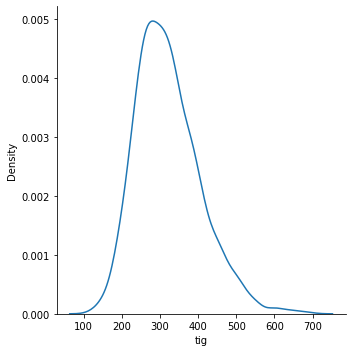

In [48]:
sns.displot(pve['tig'], kind='kde');

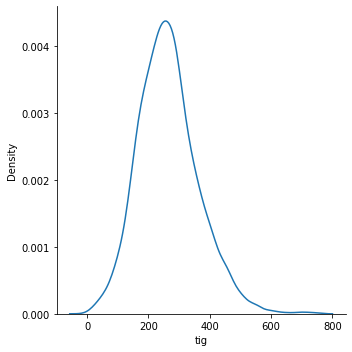

In [49]:
sns.displot(pvp['tig'], kind='kde');

**Вывод:** Данные распределены нормально (близко к нормальному)

In [50]:
#Код ревьюера
print("Всего в группах: ", len(pve) + len(pvp))

Всего в группах:  5817


In [51]:
alpha = 0.05

results = st.ttest_ind(pve['tig'], pvp['tig'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.363370007995489e-96
Отвергаем нулевую гипотезу


**Вывод:** Значение Р-value больше установленного уровня значимости alpha, следовательно, мы отклоняем нулевую гипотезу, и приходим к выводу о том, что среднее время прохождения 1 уровеня зависит от способа его прохождения. Среднее время прохождения уровня через победу над врагом - 265.4 часа, а среднее время прохождения уровня 1 через реализацию проекта - 321.5 часов


Переходим к проверке 2 гипотезы

Н0: Среднее время прохождения 1 уровня не зависит от канала привлечения игроков



Н1: Среднее время прохождения 1 уровня зависит от от канала привлечения игроков

In [52]:
level_source = game_actions.merge(game, how = 'left', on = 'user_id')
level_source = level_source[level_source['event_x'] == 'finished_stage_1']
level_source = level_source[level_source['event_y'] == 'finished_stage_1']

Как было сказано ранее, в данном случае, для упрощения анализа, будем использовать тест ANOVA

In [53]:
yandex = level_source.query('source == "yandex_direct"')
instagram = level_source.query('source == "instagram_new_adverts"')
facebook = level_source.query('source == "facebook_ads"')
youtube =  level_source.query('source == "youtube_channel_reklama"')
yandex = yandex.groupby('user_id')['TiG'].mean()
instagram = instagram.groupby('user_id')['TiG'].mean()
facebook = facebook.groupby('user_id')['TiG'].mean()
youtube = youtube.groupby('user_id')['TiG'].mean()

In [54]:

alpha = 0.05
def t_test(t, p):


    results = stats.ttest_ind(t, p, equal_var =False)

    print('p-значение: ', results.pvalue)

    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу'
        )
    
    print('\n')

In [55]:
t_test (yandex,facebook)
t_test (yandex,instagram)
t_test (yandex,youtube)
t_test (instagram,facebook)
t_test (instagram,youtube)
t_test (facebook,youtube)

p-значение:  0.8031910077867127
Не получилось отвергнуть нулевую гипотезу


p-значение:  0.5146454362409159
Не получилось отвергнуть нулевую гипотезу


p-значение:  0.4804264366633959
Не получилось отвергнуть нулевую гипотезу


p-значение:  0.7397682743804739
Не получилось отвергнуть нулевую гипотезу


p-значение:  0.9249928347636449
Не получилось отвергнуть нулевую гипотезу


p-значение:  0.6874421723178624
Не получилось отвергнуть нулевую гипотезу




**Вывод:** Значение Р-value меньше установленного уровня значимости alpha, следовательно, мы не отклоняем нулевую гипотезу, и приходим к выводу о том, что среднее время прохождения 1 уровеня не зависит от канала привлечения пользователей. Это означает, что каналы дают одинаковый по качеству трафик.

**ИТОГОВЫЙ ВЫВОД:** нами дважды был проведен t-test для выявления различный в среднем времени прохождения 1 уровня разных игроков. 1 исследование было появящено выявлению зависимсоти в среднем времени прохождения 1 уровня игроками с разными стратегиями. Результат оказался следующим: среднее время прохождения 1 уровня зависит от выбранной игроком стратегии (pvp стратегия требует значительно меньшее время на прохождение 1 уровня).



2 гипотеза была нацелена на выявления различий в среднем времени прохождения 1 уровня у игроков, пришедших с разных каналов. Было получено, что нет разницы в среднем времении прохождения 1 уровня в зависимости от канала привлечения. Таким образом, можно сказать, что качество трафика (игроков) не зависит от маркетингового канала (канала привлечения)

# ВЫВОДЫ И РЕКОМЕНДАЦИИ

Нами был проведен анализ пользователей и событий игры "Космические братья". Информация содержится о пользователях, которые скачали игру в период с 4 по 10 мая 2020 года. Помимо информации с логами игры у нас есть информация о каналах привлечения пользователей, а также о маркетинговых тратах.


На первом этапе данные были загружены и изучены. После этого необходимо было данные обработать, так как в них присутсвовали ошибки, такие как пропуски данных, дубликаты, неверный формат данных. Пропуски были заполнены, исходя из логики данных пропусков, дубликат был удален, формат данных заменен на верный.


На следующем этапе была проведен исследовательский анализ данных. Было выялвено следующее:

 - В датасете имеется информация о 13576 уникальных пользователя, которые с 4-10 марта совершили 135639 событий (уникальных 3 события). 
 
 
 
 - В основном, игроки использовали для завершения 1 уровня победу над врагом, при этом большинство игроков еще не завершили 1 уровень.
 
 
 
 - Те, игроки, которые выбрали стратегию "pve", в основном, строят космодромы.
 
 
 
 - Большинство игроков пришли из Яндекс.Директа (4817 юзеров)
 
 
 
 - Наименьшее число пришло из канала youtube_channel_reklama (2686 юзеров)
 
 
 
 - Наибольшая суммарная стоимость затрат на привлечение пользователей у канала - yandex_direct, минимальная у youtube_channel_reklama. 
 
 
 
 - Видно, что количество привлеченных юзеров кореллирует с суммарной стоимостью затрат на привлечение в каждом из каналов трафика. 
 
 
 
 - Более того, рассчитав cac, мы получили, что Яндекс.Директ при его высокой эффективности обладает одной из наименьших стоимостей привлечения юзеров
 
 
 
 - Пик активных пользователей приложения по дням приходится как раз на 4-10 мая, когда пользователи только начинают использовать приложение), далее наблюдается существенное снижение активности.
 
 
 
 - Более того, в среднем, ежедневно игрой пользуются 2884 уникальных пользователя
 
 
 
 - Игроки, которые завершили первый уровень, проводили медианно 12 дней в игре, в то время как те, кто не завершил 1 уровень, проводили в игре медианно 11 дней, то есть на 1 день меньше. 
 
 
 
 - Скорее всего, игроки просто уставали проходить 1 уровень и не желали продолжать играть дальше
 
 
 
 - Когорты 4-7 мая умеют удержания 3 дня выше 60%, что является высоким показателем, игроки в данных когортах были серьезно заинтересованы в прохождении 1 уровня)
 
  
 
 -  Нами дважды был проведен t-test для выявления различный в среднем времени прохождения 1 уровня разных игроков.
 
 
 
 - Среднее время прохождения 1 уровня зависит от выбранной игроком стратегии (pvp стратегия требует значительно меньшее время на прохождение 1 уровня).
 
 
 
 - Нет разницы в среднем времении прохождения 1 уровня в зависимости от канала привлечения. Таким образом, можно сказать, что качество трафика (игроков) не зависит от маркетингового канала (канала привлечения)
 
 
 
 

**Рекомендации**: необходимо отказаться от дорогого и неэффективного канала (Facebook_ads) в пользу либо увеличения трат на канал Яндекс.Директ или на канал Youtube (так как он недорогой с точки зрения cac, но по эффективности не уступает Facebook).

Более того, стоит доработать механику прохождения 1 уровня через реализацию проекта, видно, что у игроков возникают определенные сложности и в конце пропадает продолжать игру дальше.





Ссылка на дашборд: https://public.tableau.com/views/YandexProject_Minaev/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link